## 1. Setup and Imports

Notice how clean the imports are now!

In [13]:
# Fix OpenMP conflict
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [14]:
# Add parent directory to path
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

# NEW v0.2.0 API: Clean imports from centralized modules!
import gimbal
from gimbal import (
    DEMO_V0_1_SKELETON,              # Skeleton definition
    SyntheticDataConfig,              # Configuration dataclass
    generate_demo_sequence,           # Data generation
    build_camera_observation_model,   # Stage 2
    add_directional_hmm_prior,        # Stage 3
)
from gimbal.fit_params import initialize_from_groundtruth

print("✓ Imports successful!")
print(f"PyMC version: {pm.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Imports successful!
PyMC version: 5.26.1
NumPy version: 2.3.5


In [16]:
# Verify we're using the correct pymc_model.py and force reload
import importlib
import gimbal.pymc_model as pymc_model
print("Using pymc_model from:", pymc_model.__file__)
print("Expected path: C:\\Repositories\\GIMBAL_Python\\gimbal\\pymc_model.py")

# Force reload to pick up any changes
importlib.reload(pymc_model)
print("✓ Module reloaded successfully!")

# Re-import to get the updated version
from gimbal import build_camera_observation_model

Using pymc_model from: C:\Repositories\GIMBAL_Python\gimbal\pymc_model.py
Expected path: C:\Repositories\GIMBAL_Python\gimbal\pymc_model.py
✓ Module reloaded successfully!


### ⚠️ Important: Module Reload

If you see a `NameError: name 'log_lik_masked' is not defined`, it means the Jupyter kernel is using stale bytecode.

**Solution:** Run the cell above to force a module reload, or restart the kernel and run all cells from the beginning.

## 2. Generate Synthetic Data (New API)

### Before v0.2.0:
- Had to define skeleton structure inline
- Copy-paste 200+ lines of generation code
- Different implementations across notebooks

### After v0.2.0:
- One function call: `generate_demo_sequence()`
- Consistent across all notebooks and tests
- Easy to configure via `SyntheticDataConfig`

In [17]:
# Configure synthetic data generation
config = SyntheticDataConfig(
    T=60,   # Number of timesteps
    C=3,    # Number of cameras
    S=3,    # Number of hidden states
    kappa=8.0,           # Directional noise concentration
    obs_noise_std=5.0,   # 2D observation noise (pixels)
    occlusion_rate=0.05, # 5% random occlusions
    random_seed=42,      # Reproducibility
)

# Generate complete dataset with ONE function call!
print("Generating synthetic motion data...")
data = generate_demo_sequence(DEMO_V0_1_SKELETON, config)

print("\n✓ Data generation complete!")
print(f"  Skeleton: {len(DEMO_V0_1_SKELETON.joint_names)} joints")
print(f"  Joint names: {DEMO_V0_1_SKELETON.joint_names}")
print(f"  Timesteps: {data.config.T}")
print(f"  Cameras: {data.config.C}")
print(f"  Hidden states: {data.config.S}")
print(f"  State distribution: {np.bincount(data.true_states)}")
print(f"  Occlusions: {np.sum(np.isnan(data.y_observed))} / {data.config.C * data.config.T * len(DEMO_V0_1_SKELETON.joint_names) * 2}")

Generating synthetic motion data...

✓ Data generation complete!
  Skeleton: 6 joints
  Joint names: ['root', 'joint1', 'joint2', 'joint3', 'joint4', 'joint5']
  Timesteps: 60
  Cameras: 3
  Hidden states: 3
  State distribution: [20 21 19]
  Occlusions: 108 / 2160


In [18]:
# Initialize parameters from ground truth 3D positions
print("\nInitializing parameters from ground truth...")
init_result = initialize_from_groundtruth(
    x_gt=data.x_true,
    parents=DEMO_V0_1_SKELETON.parents,
    return_numpy=True,
)
print("✓ Initialization complete!")


Initializing parameters from ground truth...
✓ Initialization complete!


## 3. Visualize Synthetic Data

Let's inspect what was generated.

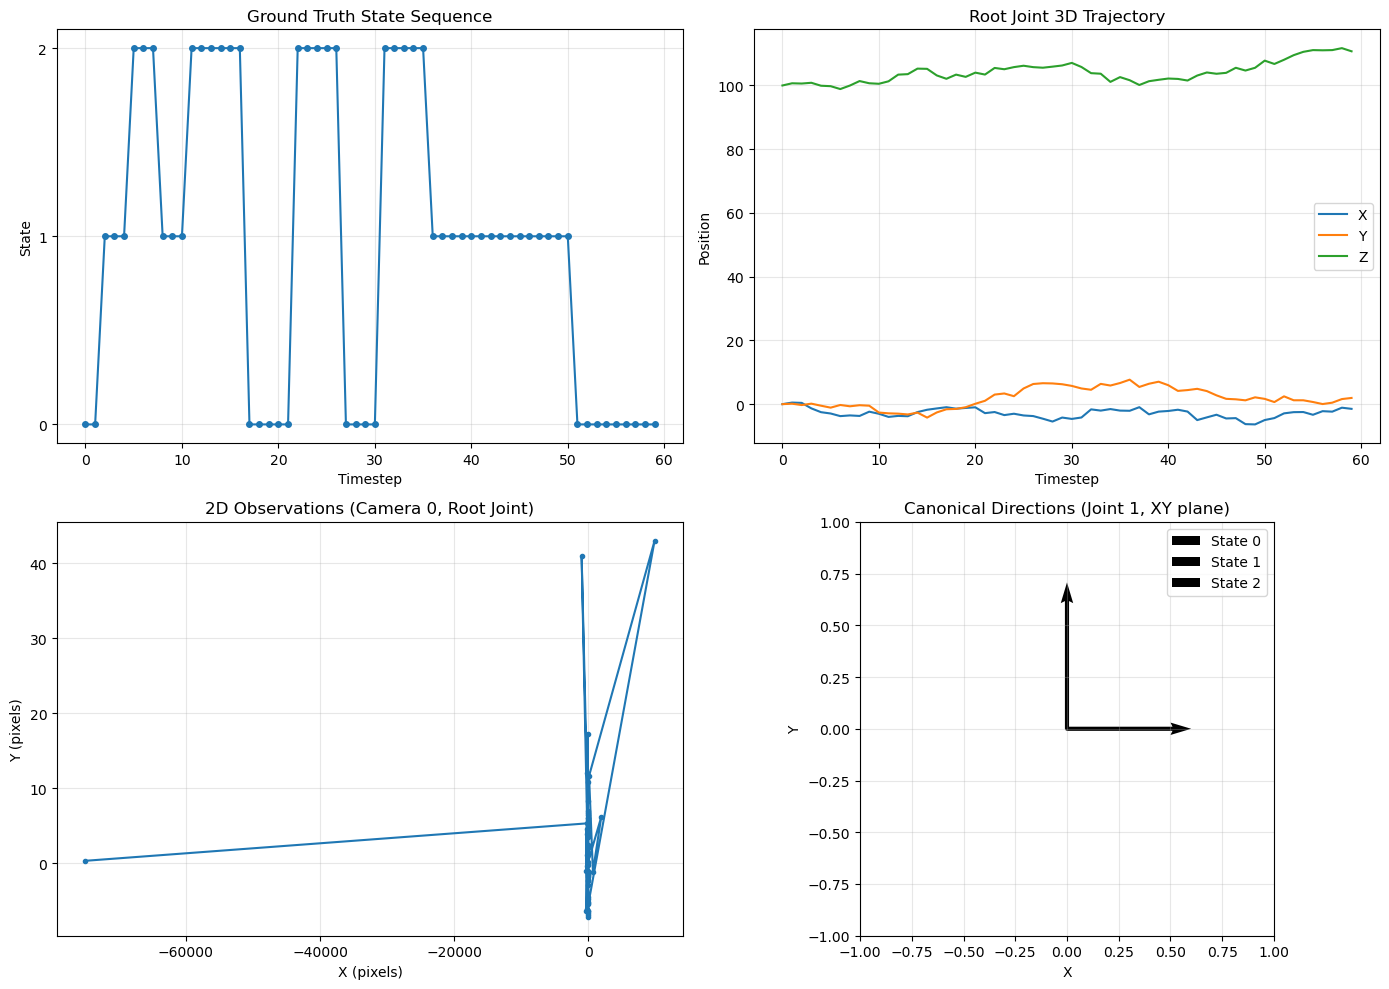


Visualization complete! ✓


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: True state sequence
axes[0, 0].plot(data.true_states, 'o-', markersize=4)
axes[0, 0].set_xlabel('Timestep')
axes[0, 0].set_ylabel('State')
axes[0, 0].set_title('Ground Truth State Sequence')
axes[0, 0].set_yticks([0, 1, 2])
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: 3D skeleton trajectories (root joint)
axes[0, 1].plot(data.x_true[:, 0, 0], label='X')
axes[0, 1].plot(data.x_true[:, 0, 1], label='Y')
axes[0, 1].plot(data.x_true[:, 0, 2], label='Z')
axes[0, 1].set_xlabel('Timestep')
axes[0, 1].set_ylabel('Position')
axes[0, 1].set_title('Root Joint 3D Trajectory')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: 2D observations (camera 0, joint 0)
axes[1, 0].plot(data.y_observed[0, :, 0, 0], data.y_observed[0, :, 0, 1], 'o-', markersize=3)
axes[1, 0].set_xlabel('X (pixels)')
axes[1, 0].set_ylabel('Y (pixels)')
axes[1, 0].set_title('2D Observations (Camera 0, Root Joint)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Canonical directions for each state
for s in range(data.config.S):
    # Show direction of joint 1 for each state
    axes[1, 1].quiver(0, 0, data.canonical_mu[s, 1, 0], data.canonical_mu[s, 1, 1],
                      angles='xy', scale_units='xy', scale=1, width=0.01,
                      label=f'State {s}')
axes[1, 1].set_xlim(-1, 1)
axes[1, 1].set_ylim(-1, 1)
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('Y')
axes[1, 1].set_title('Canonical Directions (Joint 1, XY plane)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_aspect('equal')

plt.tight_layout()
plt.show()

print("\nVisualization complete! ✓")

## 4. Build Stage 2 — Camera Observation Model

Using the new clean API from `gimbal` package.

In [20]:
print("Building Stage 2 camera observation model...\n")

with pm.Model() as model:
    # Build Stage 2: Camera + Kinematics
    build_camera_observation_model(
        y_observed=data.y_observed,
        camera_proj=data.camera_proj,
        parents=DEMO_V0_1_SKELETON.parents,
        init_result=init_result,
    )
    
    # Retrieve Stage 2 interface variables from the model
    U = model["U"]
    x_all = model["x_all"]
    y_pred = model["y_pred"]
    log_obs_t = model["log_obs_t"]
    
    print("✓ Stage 2 built successfully!")
    print(f"\nModel structure:")
    print(f"  U (directions):      {U.type.shape}")
    print(f"  x_all (positions):   {x_all.type.shape}")
    print(f"  y_pred (2D proj):    {y_pred.type.shape}")
    print(f"  log_obs_t (loglik):  {log_obs_t.type.shape}")
    print(f"\n  Free variables: {len(model.free_RVs)}")

Building Stage 2 camera observation model...



c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


✓ Stage 2 built successfully!

Model structure:
  U (directions):      (60, 6, 3)
  x_all (positions):   (60, 6, 3)
  y_pred (2D proj):    (None, 60, 6, 2)
  log_obs_t (loglik):  (60,)

  Free variables: 16


## 5. Add Stage 3 — Directional HMM Prior

The directional HMM prior adds state-dependent canonical poses over joint orientations using dot-product energy for computational efficiency.

In [21]:
print("Adding Stage 3 directional HMM prior...\n")

with model:
    # Add Stage 3: Directional HMM Prior
    hmm_vars = add_directional_hmm_prior(
        U=U,
        log_obs_t=log_obs_t,
        S=data.config.S,
        name_prefix="dir_hmm",
        share_kappa_across_joints=False,
        share_kappa_across_states=False,
        kappa_scale=5.0,
    )
    
    print("✓ Stage 3 added successfully!")
    print(f"\nHMM variables:")
    print(f"  mu (canonical dirs): {hmm_vars['mu'].type.shape}")
    print(f"  kappa (concentrations): {hmm_vars['kappa'].type.shape}")
    print(f"  logp_init: {hmm_vars['logp_init'].type.shape}")
    print(f"  logp_trans: {hmm_vars['logp_trans'].type.shape}")
    print(f"  hmm_loglik: scalar")
    
    print(f"\n  Total free variables: {len(model.free_RVs)}")
    print(f"\n✓ Complete 3-stage pipeline built!")

Adding Stage 3 directional HMM prior...

✓ Stage 3 added successfully!

HMM variables:
  mu (canonical dirs): (3, 6, 3)
  kappa (concentrations): (3, 6)
  logp_init: (3,)
  logp_trans: (3, 3)
  hmm_loglik: scalar

  Total free variables: 20

✓ Complete 3-stage pipeline built!
✓ Stage 3 added successfully!

HMM variables:
  mu (canonical dirs): (3, 6, 3)
  kappa (concentrations): (3, 6)
  logp_init: (3,)
  logp_trans: (3, 3)
  hmm_loglik: scalar

  Total free variables: 20

✓ Complete 3-stage pipeline built!


## 6. Model Validation

Let's validate the model structure using PyMC's built-in debugging.

In [22]:
print("Validating model structure...\n")

try:
    model.debug()
    print("✓ Model graph is valid!")
    print("  No shape mismatches or graph errors detected.")
except Exception as e:
    print(f"⚠ Model validation warning: {e}")

# Show model structure
print(f"\nModel Summary:")
print(f"  Free RVs: {len(model.free_RVs)}")
print(f"  Observed RVs: {len(model.observed_RVs)}")
print(f"  Deterministics: {len(model.deterministics)}")
print(f"  Potentials: {len(model.potentials)}")

print(f"\nFree variable names (first 10):")
for i, rv in enumerate(model.free_RVs[:10]):
    print(f"  {i+1}. {rv.name}")

Validating model structure...

point={'eta2_root_log__': array(1.14316382), 'rho_log__': array([2.30258509, 2.30258509, 2.07944166, 2.07944154, 1.79175947]), 'sigma2_log__': array([-9.2103404, -9.2103404, -9.2103404, -9.2103404, -9.2103404]), 'x_root': array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+02],
       [ 4.97160733e-01,  1.42425731e-01,  1.00690483e+02],
       [ 3.98675263e-01, -2.80872583e-01,  1.00610764e+02],
       [-1.32864511e+00,  1.53551072e-01,  1.00848503e+02],
       [-2.51740813e+00, -4.86200452e-01,  9.99219284e+01],
       [-2.93276548e+00, -1.09829724e+00,  9.97811356e+01],
       [-3.75415206e+00, -2.59808064e-01,  9.88782120e+01],
       [-3.53476977e+00, -6.70735300e-01,  9.99844971e+01],
       [-3.69821262e+00, -3.33160728e-01,  1.01391983e+02],
       [-2.36081433e+00, -4.87666428e-01,  1.00696037e+02],
       [-3.01496100e+00, -2.63495541e+00,  1.00533371e+02],
       [-4.00181818e+00, -2.88023329e+00,  1.01310707e+02],
       [-3.68532372e+00, -2

## 7. Prior Predictive Sampling

Let's test the model by sampling from the prior distribution.

In [23]:
print("Running prior predictive sampling...\n")

try:
    prior_pred = pm.sample_prior_predictive(
        samples=50,
        random_seed=42,
        model=model,
    )
    
    print("✓ Prior predictive sampling successful!")
    print(f"\nSampled variables (first 10):")
    var_names = list(prior_pred.prior.data_vars)
    for i, var in enumerate(var_names[:10]):
        shape = prior_pred.prior[var].shape
        print(f"  {i+1}. {var}: {shape}")
    
    print(f"\n  Total variables sampled: {len(var_names)}")
    print(f"  Number of chains: {len(prior_pred.prior.chain)}")
    print(f"  Samples per chain: {len(prior_pred.prior.draw)}")
    
except Exception as e:
    print(f"⚠ Prior predictive sampling failed: {e}")
    print("  (This might be due to initialization issues - non-critical for structure validation)")

Running prior predictive sampling...



C:\Users\User\AppData\Local\Temp\ipykernel_38520\3877270285.py:4: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_pred = pm.sample_prior_predictive(
Sampling: [dir_hmm_init_logits, dir_hmm_kappa, dir_hmm_mu_raw, dir_hmm_trans_logits, eta2_root, inlier_prob, length_1, length_2, length_3, length_4, length_5, obs_sigma, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, rho, sigma2, x_root]
Sampling: [dir_hmm_init_logits, dir_hmm_kappa, dir_hmm_mu_raw, dir_hmm_trans_logits, eta2_root, inlier_prob, length_1, length_2, length_3, length_4, length_5, obs_sigma, raw_u_1, raw_u_2, raw_u_3, raw_u_4, raw_u_5, rho, sigma2, x_root]


✓ Prior predictive sampling successful!

Sampled variables (first 10):
  1. x_root: (1, 50, 60, 3)
  2. rho: (1, 50, 5)
  3. u_2: (1, 50, 60, 3)
  4. dir_hmm_mu: (1, 50, 3, 6, 3)
  5. dir_hmm_log_dir_emit: (1, 50, 60, 3)
  6. raw_u_4: (1, 50, 60, 3)
  7. U: (1, 50, 60, 6, 3)
  8. dir_hmm_potential: (1, 50)
  9. dir_hmm_mu_raw: (1, 50, 3, 6, 3)
  10. dir_hmm_trans_logits: (1, 50, 3, 3)

  Total variables sampled: 41
  Number of chains: 1
  Samples per chain: 50


## 8. Visualize Prior Samples

Let's look at samples from the directional HMM prior.

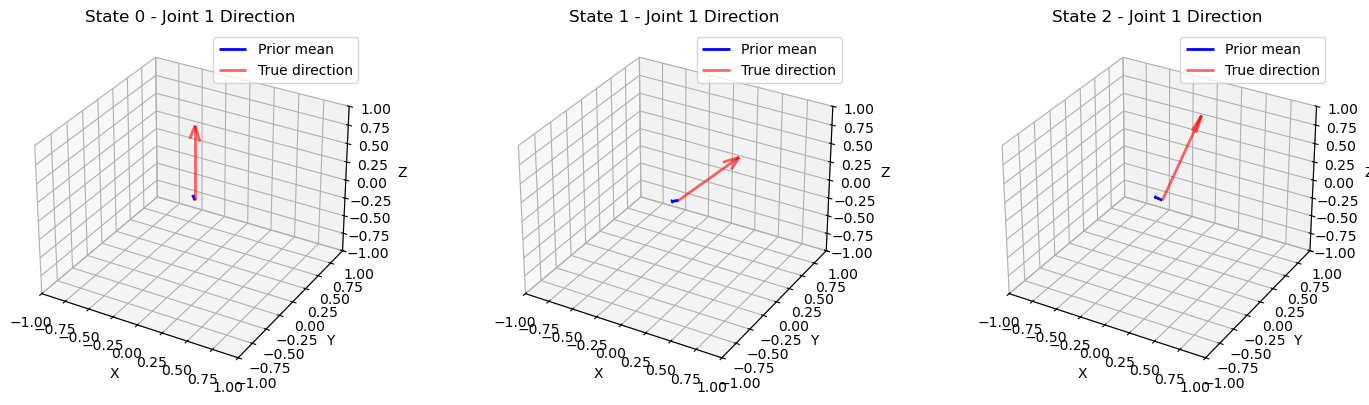


✓ Prior visualization complete!


In [24]:
# Extract canonical direction samples
mu_samples = prior_pred.prior['dir_hmm_mu'].values  # (chains, draws, S, K, 3)

# Plot posterior mean canonical directions
fig = plt.figure(figsize=(15, 4))

for s in range(data.config.S):
    ax = fig.add_subplot(1, 3, s + 1, projection='3d')
    
    # Get mean direction for joint 1 across all samples
    mu_mean = mu_samples[:, :, s, 1, :].mean(axis=(0, 1))  # (3,)
    
    # Plot in 3D projection
    ax.quiver(0, 0, 0, mu_mean[0], mu_mean[1], mu_mean[2],
              color='blue', arrow_length_ratio=0.2, linewidth=2,
              label='Prior mean')
    
    # Plot true canonical direction
    true_mu = data.canonical_mu[s, 1, :]  # (3,)
    ax.quiver(0, 0, 0, true_mu[0], true_mu[1], true_mu[2],
              color='red', arrow_length_ratio=0.2, linewidth=2, alpha=0.6,
              label='True direction')
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'State {s} - Joint 1 Direction')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Prior visualization complete!")

## 9. Summary — v0.2.0 Improvements

### Code Quality Improvements ✨

| Aspect | Before v0.2.0 | After v0.2.0 |
|--------|---------------|---------------|
| **Skeleton Definition** | Inline in every notebook (copy-paste) | `DEMO_V0_1_SKELETON` constant |
| **Synthetic Data** | 200+ lines per notebook | `generate_demo_sequence()` |
| **API Imports** | Deep module paths | Clean `import gimbal` |
| **Torch Code** | Mixed with PyMC | Separated in `torch_legacy/` |
| **Documentation** | Scattered | Centralized in README |
| **Future Extensibility** | Hard to add priors | `prior_config` parameter |

### Lines of Code Reduced

- **Per notebook**: ~200 lines (synthetic data generation)
- **Total across 4 notebooks**: ~800 lines eliminated
- **New centralized modules**: ~600 lines (reusable)
- **Net reduction**: ~200 lines + much better maintainability!

### Backward Compatibility ✓

All v0.1 code still works! The restructuring is purely organizational:
- No mathematical changes to Stage 1-3
- Default behavior preserved
- Optional new features (like `prior_config`) default to v0.1 behavior

---

## Next Steps: v0.2.1–0.2.8

With the clean foundation from v0.2.0, we're ready for:

- **v0.2.1**: Coarse anatomical priors & sanity filters
- **v0.2.2**: k-means clustering empirical-Bayes priors
- **v0.2.3**: Sampler comparison (nutpie vs alternatives)
- **v0.2.4**: Diagnostic framework & label switching
- **v0.2.5**: AIST++ dataset loader
- **v0.2.6**: Real-data diagnostics
- **v0.2.7**: PCA-based dimensionality reduction
- **v0.2.8**: State-number selection

### Try It Yourself!

```python
# Clean v0.2.0 API
import gimbal

data = gimbal.generate_demo_sequence(gimbal.DEMO_V0_1_SKELETON)

with pm.Model() as model:
    _, U, _, _, log_obs_t = gimbal.build_camera_observation_model(
        y_obs=data.y_observed,
        proj_param=data.camera_proj,
        parents=gimbal.DEMO_V0_1_SKELETON.parents,
        bone_lengths=gimbal.DEMO_V0_1_SKELETON.bone_lengths,
    )
    gimbal.add_directional_hmm_prior(U, log_obs_t, S=3)
```

That's it! 🎉